Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-12-28 Python-3.10.12 torch-2.5.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


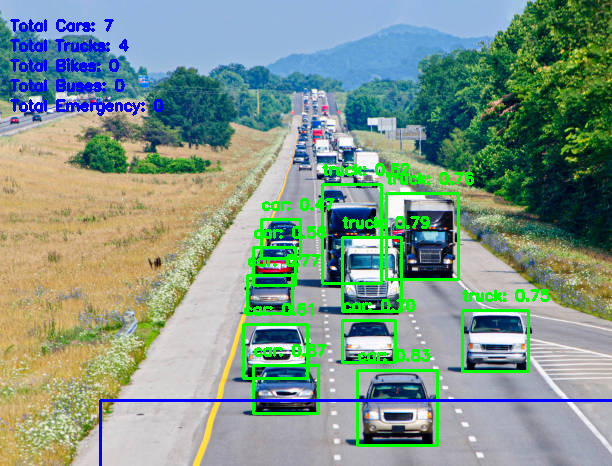

True

In [9]:
import torch
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

# Path to the image
image_path = r"/content/WhatsApp Image 2024-12-27 at 11.35.46 AM (1).jpeg"

# Read the image
frame = cv2.imread(image_path)

# Initialize counters for vehicle types
car_count = 0
truck_count = 0
bike_count = 0
bus_count = 0
emergency_count = 0
queue_length = 0  # Variable to count the queue length

# Define HSV color ranges for red and blue
red_lower1 = np.array([0, 50, 50])
red_upper1 = np.array([10, 255, 255])
red_lower2 = np.array([170, 50, 50])
red_upper2 = np.array([180, 255, 255])

blue_lower = np.array([100, 150, 0])
blue_upper = np.array([140, 255, 255])

def detect_emergency_lights(roi):
    """Detect emergency lights (red and blue) in the given ROI."""
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # Red mask
    red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
    red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)

    # Blue mask
    blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)

    # Find contours for red and blue masks
    red_contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    blue_contours, _ = cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check for significant red and blue regions
    red_detected = any(cv2.contourArea(c) > 200 for c in red_contours)  # Adjust area threshold
    blue_detected = any(cv2.contourArea(c) > 200 for c in blue_contours)

    return red_detected and blue_detected

# Perform inference
results = model(frame)

# Process the results
df = results.pandas().xyxy[0]  # Extract predictions as a DataFrame

# Define the region where you want to count vehicles for the queue (e.g., a traffic lane)
roi_top_left = (100, 400)  # Top-left corner of the ROI (modify these values based on the image)
roi_bottom_right = (800, 600)  # Bottom-right corner of the ROI (modify these values based on the image)

for index, row in df.iterrows():
    x1, y1, x2, y2, conf, cls = row[['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class']].values
    label = f'{model.names[int(cls)]}: {conf:.2f}'

    # Ensure minimum size for ROI
    if (x2 - x1) < 30 or (y2 - y1) < 30:
        continue  # Skip small detections

    # Extract the ROI for color detection
    roi = frame[int(y1):int(y2), int(x1):int(x2)]

    # Check if the detected object is a vehicle
    vehicle_type = model.names[int(cls)]
    if vehicle_type in ['car', 'truck', 'bus']:
        if detect_emergency_lights(roi):
            emergency_count += 1
            label = 'Emergency Vehicle'
        else:
            # Count vehicles based on class
            if vehicle_type == 'car':
                car_count += 1
            elif vehicle_type == 'truck':
                truck_count += 1
            elif vehicle_type == 'bus':
                bus_count += 1
    elif vehicle_type == 'motorcycle':
        bike_count += 1

    # Check if the bounding box is within the ROI for queue counting
    if x1 > roi_top_left[0] and y1 > roi_top_left[1] and x2 < roi_bottom_right[0] and y2 < roi_bottom_right[1]:
        queue_length += 1  # Increment queue length if the vehicle is in the defined region

    # Draw bounding box and label on the frame
    cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    cv2.putText(frame, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display vehicle counts on the frame
cv2.putText(frame, f'Total Cars: {car_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
cv2.putText(frame, f'Total Trucks: {truck_count}', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
cv2.putText(frame, f'Total Bikes: {bike_count}', (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
cv2.putText(frame, f'Total Buses: {bus_count}', (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
cv2.putText(frame, f'Total Emergency: {emergency_count}', (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Draw the ROI on the image (optional, for visualization)
cv2.rectangle(frame, roi_top_left, roi_bottom_right, (255, 0, 0), 2)

# Show the image with detections using cv2_imshow
cv2_imshow(frame)

# Save the output image
output_path = r"/content/output_image.jpg"
cv2.imwrite(output_path, frame)
